# Deep Deterministic Policy Gradients Paper Implement

* need reply buffer class
* need a for a target Q-net f(s,a)
* will use batch norm
* policy is deterministic, exploit vs explore
* (deterministic ploicy means outputs actual actions isntead of probablity)
* will need a way to bound the actions to the env limits
* 2 actors, 2 critic nets, a target for each
* updates are soft, according to theta_prime = tau*theta + (1-tau)*theta_prime, tau << 1
* target actor is just evaluation actor + some noise
* they used Ornstien Uhlnbeck. --> will need class for noise

In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, Dense

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

In [3]:
class OUActionNoise(object):
    def __init__(self, mu, sigma=0.15, theta=.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(
                                                            self.mu, self.sigma)

In [4]:
class ReplayBuffer:
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

In [5]:
class CriticNetwork(keras.Model):
    def __init__(self, fc1_dims=512, fc2_dims=512,
            name='critic', chkpt_dir='tmp/ddpg'):
        super(CriticNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, 
                    self.model_name+'_ddpg.h5')

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.q = Dense(1, activation=None)

    def call(self, state, action):
        action_value = self.fc1(tf.concat([state, action], axis=1))
        action_value = self.fc2(action_value)

        q = self.q(action_value)

        return q

class ActorNetwork(keras.Model):
    def __init__(self, fc1_dims=512, fc2_dims=512, n_actions=2, name='actor',
            chkpt_dir='tmp/ddpg'):
        super(ActorNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, 
                    self.model_name+'_ddpg.h5')

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.mu = Dense(self.n_actions, activation='tanh')

    def call(self, state):
        prob = self.fc1(state)
        prob = self.fc2(prob)

        mu = self.mu(prob)

        return mu

In [6]:
class Agent:
    def __init__(self, input_dims, alpha=0.001, beta=0.002, env=None,
                 gamma=0.99, n_actions=2, max_size=1000000, tau=0.005,
                 fc1=400, fc2=300, batch_size=64, noise=0.1):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.noise = noise
        self.max_action = env.action_space.high[0]
        self.min_action = env.action_space.low[0]

        self.actor = ActorNetwork(n_actions=n_actions, name='actor')
        self.critic = CriticNetwork(name='critic')
        self.target_actor = ActorNetwork(n_actions=n_actions,
                                         name='target_actor')
        self.target_critic = CriticNetwork(name='target_critic')

        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic.compile(optimizer=Adam(learning_rate=beta))
        self.target_actor.compile(optimizer=Adam(learning_rate=alpha))
        self.target_critic.compile(optimizer=Adam(learning_rate=beta))

        self.update_network_parameters(tau=1)

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.target_actor.weights
        for i, weight in enumerate(self.actor.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.target_actor.set_weights(weights)

        weights = []
        targets = self.target_critic.weights
        for i, weight in enumerate(self.critic.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.target_critic.set_weights(weights)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_weights(self.actor.checkpoint_file)
        self.target_actor.save_weights(self.target_actor.checkpoint_file)
        self.critic.save_weights(self.critic.checkpoint_file)
        self.target_critic.save_weights(self.target_critic.checkpoint_file)

    def load_models(self):
        print('... loading models ...')
        self.actor.load_weights(self.actor.checkpoint_file)
        self.target_actor.load_weights(self.target_actor.checkpoint_file)
        self.critic.load_weights(self.critic.checkpoint_file)
        self.target_critic.load_weights(self.target_critic.checkpoint_file)

    def choose_action(self, observation, evaluate=False):
        state = tf.convert_to_tensor([observation], dtype=tf.float32)
        actions = self.actor(state)
        if not evaluate:
            actions += tf.random.normal(shape=[self.n_actions],
                                        mean=0.0, stddev=self.noise)
        # note that if the env has an action > 1, we have to multiply by
        # max action at some point
        actions = tf.clip_by_value(actions, self.min_action, self.max_action)

        return actions[0]

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        state, action, reward, new_state, done = \
            self.memory.sample_buffer(self.batch_size)

        states = tf.convert_to_tensor(state, dtype=tf.float32)
        states_ = tf.convert_to_tensor(new_state, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)

        with tf.GradientTape() as tape:
            target_actions = self.target_actor(states_)
            critic_value_ = tf.squeeze(self.target_critic(
                                states_, target_actions), 1)
            critic_value = tf.squeeze(self.critic(states, actions), 1)
            target = rewards + self.gamma*critic_value_*(1-done)
            critic_loss = keras.losses.MSE(target, critic_value)

        critic_network_gradient = tape.gradient(critic_loss,
                                                self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(zip(
            critic_network_gradient, self.critic.trainable_variables))

        with tf.GradientTape() as tape:
            new_policy_actions = self.actor(states)
            actor_loss = -self.critic(states, new_policy_actions)
            actor_loss = tf.math.reduce_mean(actor_loss)

        actor_network_gradient = tape.gradient(actor_loss,
                                               self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(
            actor_network_gradient, self.actor.trainable_variables))

        self.update_network_parameters()

# Testing!

In [7]:
import gym
np.random.seed(0)

<ipython-input-4-e6fe9f0a0db2>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)


... saving models ...
episode  0 score -1178.9 avg score -1178.9
episode  1 score -1673.1 avg score -1426.0
episode  2 score -1582.1 avg score -1478.0
episode  3 score -1635.2 avg score -1517.3
episode  4 score -1813.9 avg score -1576.6
episode  5 score -906.1 avg score -1464.9
episode  6 score -1458.2 avg score -1463.9
episode  7 score -1638.1 avg score -1485.7
episode  8 score -1837.4 avg score -1524.8
episode  9 score -1663.1 avg score -1538.6
episode  10 score -1572.1 avg score -1541.7
episode  11 score -1838.2 avg score -1566.4
episode  12 score -1748.3 avg score -1580.4
episode  13 score -1105.3 avg score -1546.4
episode  14 score -1366.7 avg score -1534.4
episode  15 score -999.6 avg score -1501.0
episode  16 score -866.0 avg score -1463.7
episode  17 score -985.3 avg score -1437.1
episode  18 score -743.4 avg score -1400.6
episode  19 score -1846.7 avg score -1422.9
episode  20 score -1484.7 avg score -1425.8
episode  21 score -1029.4 avg score -1407.8
episode  22 score -1133.2

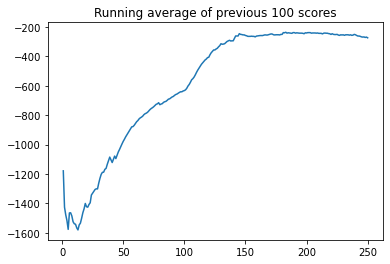

In [9]:
env = gym.make('Pendulum-v1')
agent = Agent(input_dims=env.observation_space.shape, env=env,
        n_actions=env.action_space.shape[0])
n_games = 250

figure_file = 'plots/pendulum.png'

best_score = env.reward_range[0]
score_history = []
load_checkpoint = False

if load_checkpoint:
    n_steps = 0
    while n_steps <= agent.batch_size:
        observation = env.reset()
        action = env.action_space.sample()
        observation_, reward, done, info = env.step(action)
        agent.remember(observation, action, reward, observation_, done)
        n_steps += 1
    agent.learn()
    agent.load_models()
    evaluate = True
else:
    evaluate = False

for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action = agent.choose_action(observation, evaluate)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.remember(observation, action, reward, observation_, done)
        if not load_checkpoint:
            agent.learn()
        observation = observation_

    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        if not load_checkpoint:
            agent.save_models()

    print('episode ', i, 'score %.1f' % score, 'avg score %.1f' % avg_score)

if not load_checkpoint:
    x = [i+1 for i in range(n_games)]
    plot_learning_curve(x, score_history, figure_file)